# Fraudulent Job Postings

In [2]:
# Load required libraries

#Exploratory 
import pandas as pd
import numpy as np
import missingno

#Data Visualization 
import seaborn as sns
import folium
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud


# sklearn
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline


#Preprocessing
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re

#Spacy
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English


#Data Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC


#Data Evaluation 
from imblearn.over_sampling import SMOTE

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')


## Data Understanding

In [3]:
df = pd.read_csv('../Data/fake_job_postings.csv', index_col=0)
df.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [4]:
df.shape

(17880, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [6]:
#!pip install missingno

<AxesSubplot:>

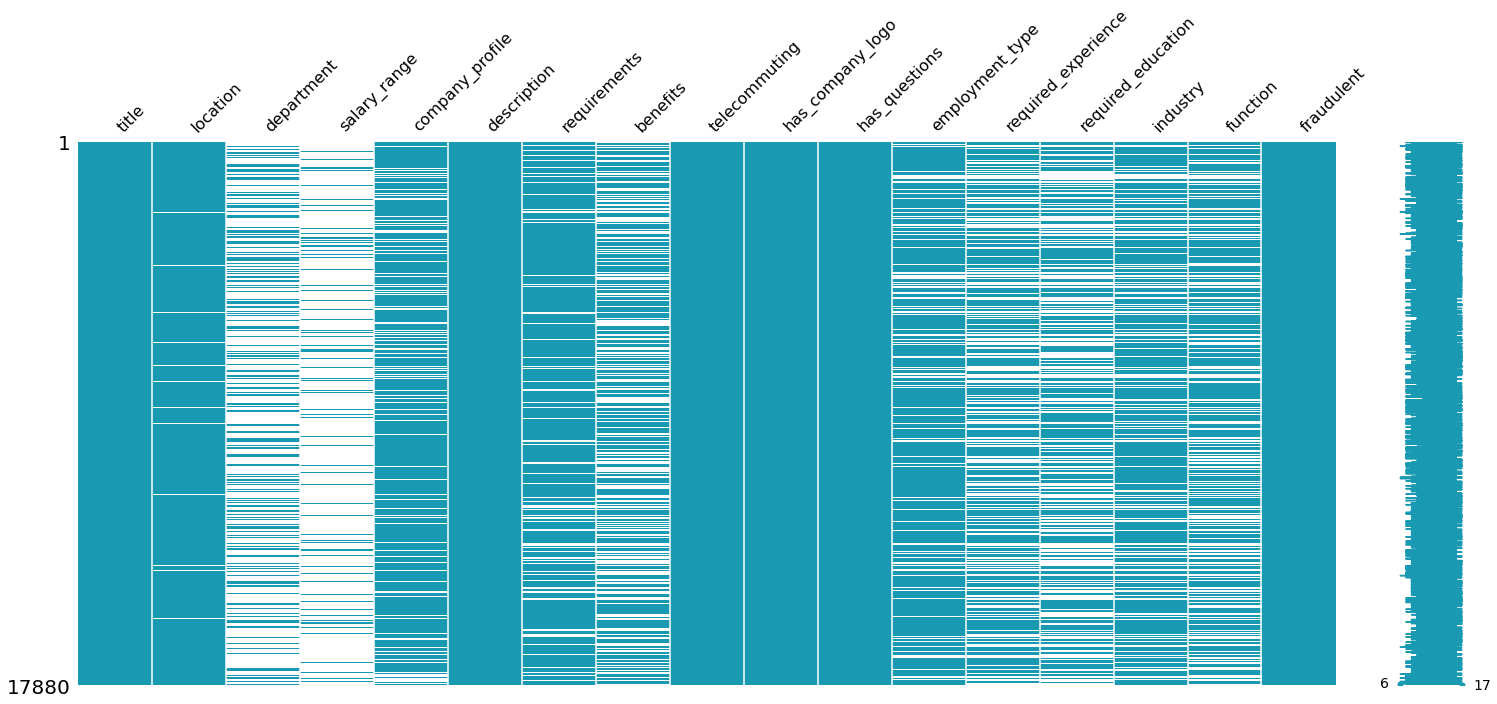

In [7]:
# checking missing data in our dataframe.
missingno.matrix(df,color=(0.1, 0.6, 0.7))

- oh wow lots of missing values

In [8]:
df.describe()

,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000
mean,0.042897,0.795302,0.491723,0.048434
std,0.202631,0.403492,0.499945,0.214688
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


### Target
- Fraudulent

In [9]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

- First Row

In [10]:
df.description[1]

'Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff'

In [11]:
df.requirements[1]

'Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooking with the seasonsMeticulous editor, perfectionist, obsessive attention to detail, maddened by typos and broken links, delighted by finding and fixing themCheerful under pressureExcellent communication skillsA+ multi-tasker and juggler of responsibilities big and smallInterested in and engaged with social media like Twitter, Facebook, and PinterestLoves problem-solving and collaborating to drive Food52 forwardThinks big picture but pitches in on the nitty gritty of running a small company (dishes, shopping, administrative support)Comfortable with the realities of working for a startup: being on call on evenings and weekends, and working long hours'

In [12]:
df.benefits[1]

nan

In [13]:
df.location.value_counts()

GB, LND, London                                  718
US, NY, New York                                 658
US, CA, San Francisco                            472
GR, I, Athens                                    464
US, ,                                            339
                                                ... 
GB, SHF, Hathersage                                1
US, CA, Silicon Valley/San Jose - Santa Clara      1
GB, BKM, Bletchley                                 1
GB, WBK, Maidenhead                                1
US, LA, Eunice                                     1
Name: location, Length: 3105, dtype: int64

# Data Viz

### Fraudulent vs Not Fraudulent

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

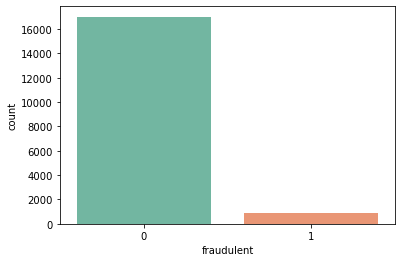

In [14]:
sns.countplot(x='fraudulent', 
              data=df,
              palette= "Set2")

### Fraudulent ads have company logo?

<AxesSubplot:xlabel='has_company_logo', ylabel='count'>

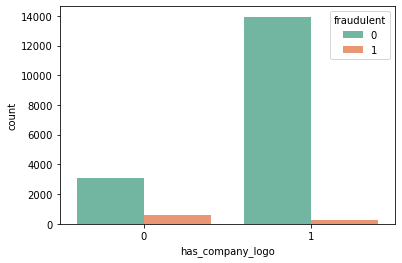

In [15]:
sns.countplot(x='has_company_logo', 
              hue='fraudulent', 
              data=df,
              palette= "Set2")

### Fraudulent ads have questions?

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

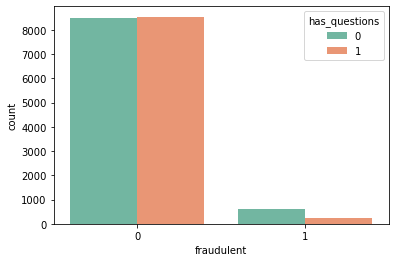

In [16]:
sns.countplot(x='fraudulent', 
              hue='has_questions', 
              data=df,
              palette= "Set2")

### Correlation between Telecommuning and fraudulent ads?

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

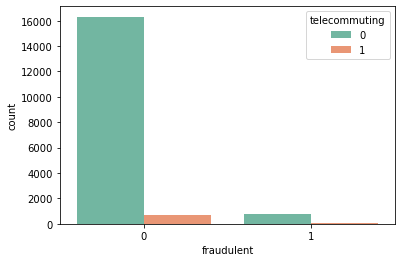

In [17]:
sns.countplot(x='fraudulent', 
              hue='telecommuting', 
              data=df,
              palette= "Set2")

### Any Department in particular that shows more fraudulence ?

In [18]:
df.department.value_counts().head(30)

Sales                     551
Engineering               487
Marketing                 401
Operations                270
IT                        225
Development               146
Product                   112
Information Technology     86
Design                     76
Technology                 76
Customer Service           73
Finance                    69
HR                         56
tech                       55
R&D                        54
Creative                   48
Retail                     45
Client Services            45
Product Development        36
Production                 32
Business Development       32
Oil and Gas                32
CSD Relay                  31
Maintenance                30
Administrative             30
Accounting                 29
Technical                  29
Human Resources            29
Tech                       29
Administration             28
Name: department, dtype: int64

### First recommendation => Do selection for department and industry

In [19]:
df.industry.value_counts().head(30)

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Retail                                  223
Real Estate                             175
Accounting                              159
Construction                            158
E-Learning                              139
Management Consulting                   130
Design                                  129
Health, Wellness and Fitness            127
Staffing and Recruiting                 127
Insurance                               123
Automotive                              120
Logistics and Supply Chain              112
Human Resources                 

### Fraudulent vs required_experience

In [20]:
df.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

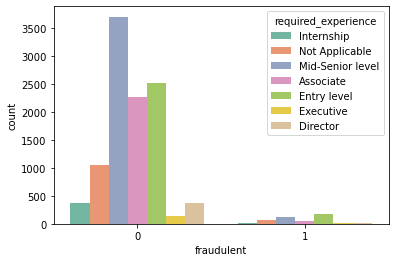

In [21]:
sns.countplot(x='fraudulent', 
              hue='required_experience', 
              data=df,
              palette= "Set2")

Well surprise surprise, looks like Entry level has something to say

### employment_type vs fraudulent

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

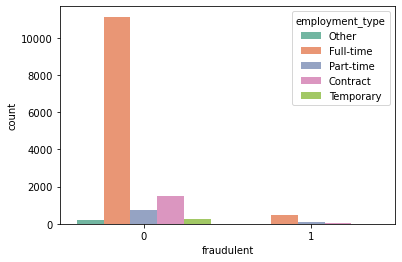

In [22]:
sns.countplot(x='fraudulent', 
              hue='employment_type', 
              data=df,
              palette= "Set2")

## Correlation

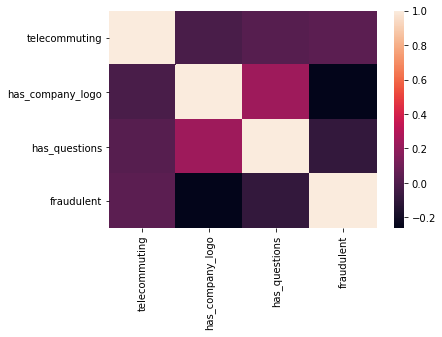

In [23]:
numeric = [col for col in df.columns if df.dtypes[col] == np.int64 or df.dtypes[col] == np.float64]
sns.heatmap(df[numeric].corr());

In [24]:
corr_abs = df.corr().abs()

compare = (corr_abs.where(np.triu(np.ones(corr_abs.shape),k=1).astype(np.bool))
       .stack()
       .sort_values(ascending=False))
compare

has_company_logo  fraudulent          0.261971
                  has_questions       0.233932
has_questions     fraudulent          0.091627
telecommuting     fraudulent          0.034523
                  has_questions       0.020345
                  has_company_logo    0.019836
dtype: float64

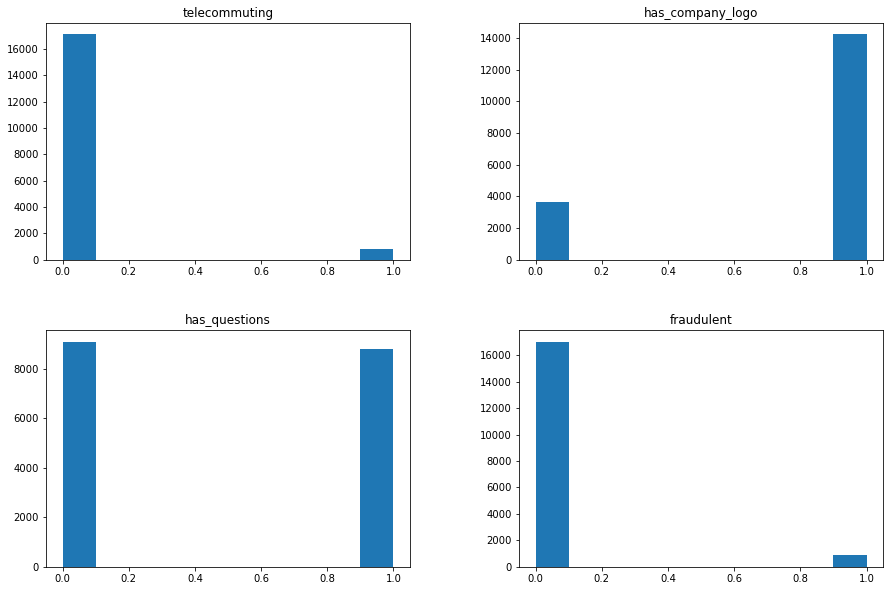

In [25]:
#for numerical
df.hist(grid= False, figsize = (15,10),);

- Check to see if null in benefits and requirements cols tell me anything

In [26]:
test = df
test['has_benefit'] = pd.notnull(test["benefits"])
test['has_requirements'] = pd.notnull(test["requirements"])
test.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements
job_id,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True


<AxesSubplot:xlabel='fraudulent', ylabel='count'>

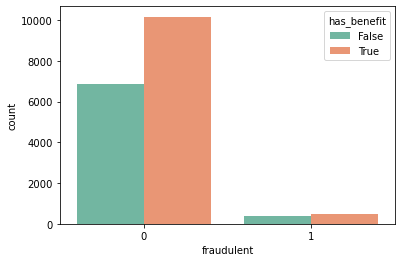

In [27]:
sns.countplot(x='fraudulent', 
              hue='has_benefit', 
              data=test,
              palette= "Set2")

<AxesSubplot:xlabel='fraudulent', ylabel='count'>

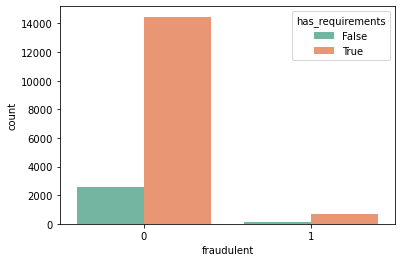

In [28]:
sns.countplot(x='fraudulent', 
              hue='has_requirements', 
              data=test,
              palette= "Set2",)

## Data Prep

In [29]:
df.location

job_id
1            US, NY, New York
2              NZ, , Auckland
3               US, IA, Wever
4          US, DC, Washington
5          US, FL, Fort Worth
                 ...         
17876         CA, ON, Toronto
17877    US, PA, Philadelphia
17878         US, TX, Houston
17879           NG, LA, Lagos
17880       NZ, N, Wellington
Name: location, Length: 17880, dtype: object

In [30]:
def split(location):
    contries = location.split(" , ")
    print(contries)
    return contries[0]


In [31]:
# df['country'] = df.location.apply(split)

- Oh well, prob not even important 

### Dealing with missing values from requirements and benefits

In [32]:
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_benefit', 'has_requirements'],
      dtype='object')

In [33]:
# Fill nulls with 'no benefit listed'
df['benefits'] = df['benefits'].fillna('no benefit listed')


In [34]:
# Fill nulls with 'no requirement listed'
df['requirements'] = df['requirements'].fillna('no requirement listed')


In [35]:
# Fill nulls with 'no description listed'
df['description'] = df['description'].fillna('no description listed')


In [36]:
# Fill nulls with 'no required_experience listed'
df['required_experience'] = df['required_experience'].fillna('no required_experience listed')

In [37]:
df.description.isna().sum()

0

In [38]:
df.loc[17514]

title                                 Office Manager
location                              PL, MZ, Warsaw
department                                       NaN
salary_range                                     NaN
company_profile                                  NaN
description                    no description listed
requirements                   no requirement listed
benefits                           no benefit listed
telecommuting                                      0
has_company_logo                                   0
has_questions                                      0
employment_type                                  NaN
required_experience    no required_experience listed
required_education                               NaN
industry                                         NaN
function                                         NaN
fraudulent                                         1
has_benefit                                    False
has_requirements                              

 ### Combining our text data in a single column to start the cleaning  process

In [150]:
# 
df['text'] = '  '+ df['title'] +'  '+ df['description'] +'  '+ df['requirements']+'  '+ df['benefits']+'  '+ df['required_experience']
df

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,has_benefit,has_requirements,text
job_id,,,,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,no benefit listed,0,1,0,Other,Internship,NaN,NaN,Marketing,0,False,True,"Marketing Intern Food52, a fast-growing, Ja..."
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,True,True,Customer Service - Cloud Video Production O...
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,no benefit listed,0,1,0,NaN,no required_experience listed,NaN,NaN,NaN,0,False,True,Commissioning Machinery Assistant (CMA) Our...
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,True,True,Account Executive - Washington DC THE COMPA...
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,True,True,Bill Review Manager JOB TITLE: Itemization ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,True,True,Account Director - Distribution Just in ca...
17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,True,True,Payroll Accountant The Payroll Accountant w...
17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,no benefit listed,0,0,0,Full-time,no required_experience listed,NaN,NaN,NaN,0,False,True,Project Cost Control Staff Engineer - Cost C...


In [151]:
# types of words are frequent in fraudulent and not fraudulent

fraud_jobs_text = df[df.fraudulent==1].text
actual_jobs_text = df[df.fraudulent==0].text

In [152]:
actual_jobs_text

job_id
1          Marketing Intern  Food52, a fast-growing, Ja...
2          Customer Service - Cloud Video Production  O...
3          Commissioning Machinery Assistant (CMA)  Our...
4          Account Executive - Washington DC  THE COMPA...
5          Bill Review Manager  JOB TITLE: Itemization ...
                               ...                        
17876      Account Director - Distribution   Just in ca...
17877      Payroll Accountant  The Payroll Accountant w...
17878      Project Cost Control Staff Engineer - Cost C...
17879      Graphic Designer  Nemsia Studios is looking ...
17880      Web Application Developers  Who are we?Vend ...
Name: text, Length: 17014, dtype: object

In [153]:
actual_jobs_text.value_counts().sum()

17014

In [154]:
fraud_jobs_text.value_counts().sum()

866

In [155]:
fraud_jobs_text

job_id
99         IC&E Technician  IC&amp;E Technician | Baker...
145        Forward Cap.  The group has raised a fund fo...
174        Technician Instrument & Controls   Technicia...
181        Sales Executive  Sales Executive  Sales Exec...
216        IC&E Technician Mt Poso  IC&amp;E Technician...
                               ...                        
17828      Student Positions Part-Time and Full-Time.  ...
17829      Sales Associate  LEARN TO EARN AN EXECUTIVE ...
17830      Android Developer  inFullMobile Sp. z o.o. i...
17831      Payroll Clerk   JOB DESCRIPTIONWe are seekin...
17832      Furniture mover  earn $500 to $1000 a week a...
Name: text, Length: 866, dtype: object

## Fraudulent Words!!!  X

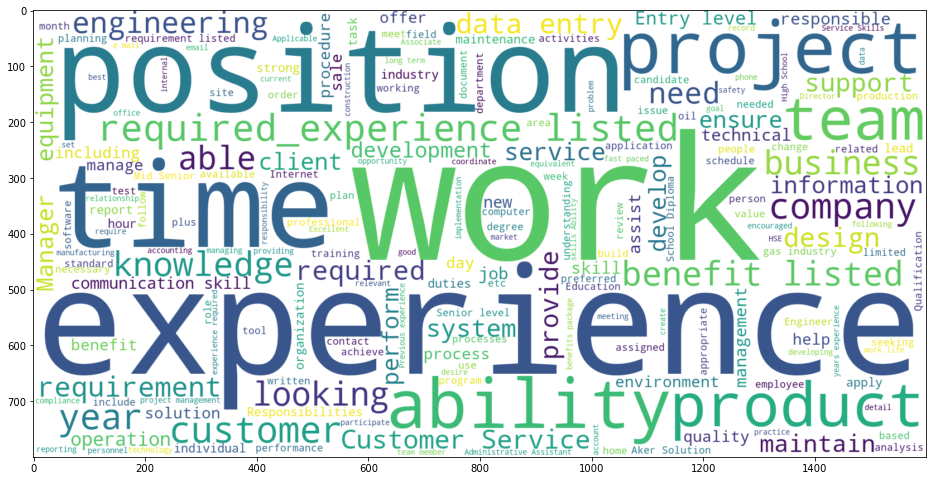

In [45]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               #max_words = 300, 
               width = 1600, 
               height = 800,
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`

## Not Fraudulent Words! lol ✓

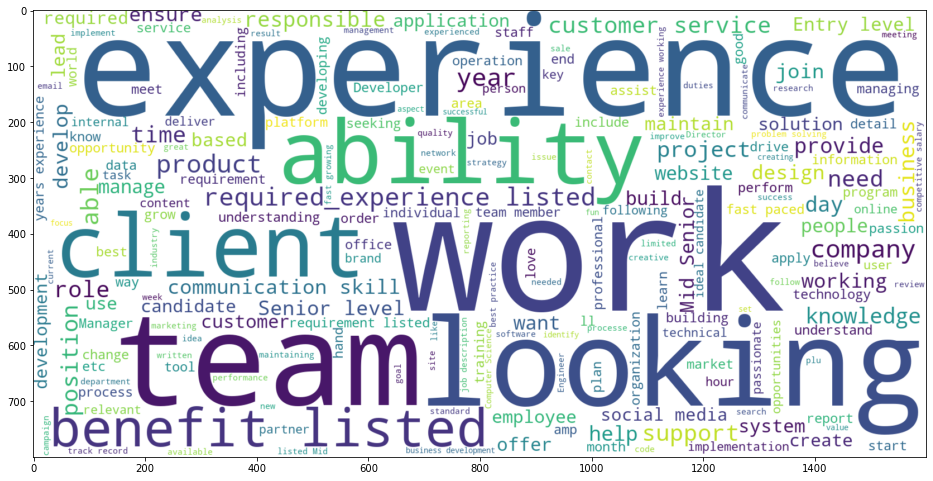

In [46]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,14))
wc = WordCloud(min_font_size = 3,  
               #max_words = 300, 
               width = 1600, 
               height = 800, 
               background_color='white',
               stopwords = STOPWORDS).generate(str(" ".join(actual_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

## Data Cleaning

In [47]:
#!python -m spacy download en_core_web_sm

In [156]:
data = df

In [157]:
# only need target and text
data = data[["fraudulent", "text"]]
data

,fraudulent,text
job_id,,
1,0,"Marketing Intern Food52, a fast-growing, Ja..."
2,0,Customer Service - Cloud Video Production O...
3,0,Commissioning Machinery Assistant (CMA) Our...
4,0,Account Executive - Washington DC THE COMPA...
5,0,Bill Review Manager JOB TITLE: Itemization ...
...,...,...
17876,0,Account Director - Distribution Just in ca...
17877,0,Payroll Accountant The Payroll Accountant w...
17878,0,Project Cost Control Staff Engineer - Cost C...


In [158]:
df.text.isna().sum()

0

# Modelling

Trying with Spacy

In [51]:
# import string
# from spacy.lang.en.stop_words import STOP_WORDS
# from spacy.lang.en import English

In [52]:
# Taken from: https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/


In [163]:

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [164]:
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [165]:
type(df.text[1])

str

In [182]:
mytest = parser(df.text[1])
mytest

  Marketing Intern  Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff  Experience with content management systems a major plus (any blogging cou

In [225]:
 #[ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytest ]

In [168]:

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [169]:
spacy_tokenizer(df.text[1])

[]

#### Trying with nltk

In [183]:
#from nltk.tokenize import word_tokenize

In [116]:
# import nltk
# nltk.download('punkt')
  

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mellissavalle/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [208]:
this = df.text[1]

In [162]:
word_tokenize(df.text[1])

['Marketing',
 'Intern',
 'Food52',
 ',',
 'a',
 'fast-growing',
 ',',
 'James',
 'Beard',
 'Award-winning',
 'online',
 'food',
 'community',
 'and',
 'crowd-sourced',
 'and',
 'curated',
 'recipe',
 'hub',
 ',',
 'is',
 'currently',
 'interviewing',
 'full-',
 'and',
 'part-time',
 'unpaid',
 'interns',
 'to',
 'work',
 'in',
 'a',
 'small',
 'team',
 'of',
 'editors',
 ',',
 'executives',
 ',',
 'and',
 'developers',
 'in',
 'its',
 'New',
 'York',
 'City',
 'headquarters.Reproducing',
 'and/or',
 'repackaging',
 'existing',
 'Food52',
 'content',
 'for',
 'a',
 'number',
 'of',
 'partner',
 'sites',
 ',',
 'such',
 'as',
 'Huffington',
 'Post',
 ',',
 'Yahoo',
 ',',
 'Buzzfeed',
 ',',
 'and',
 'more',
 'in',
 'their',
 'various',
 'content',
 'management',
 'systemsResearching',
 'blogs',
 'and',
 'websites',
 'for',
 'the',
 'Provisions',
 'by',
 'Food52',
 'Affiliate',
 'ProgramAssisting',
 'in',
 'day-to-day',
 'affiliate',
 'program',
 'support',
 ',',
 'such',
 'as',
 'screeni

In [170]:
#from sklearn.base import TransformerMixin

In [216]:
# Custom transformer 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [217]:
#from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [218]:
# creating our bag of words
bow_vector = CountVectorizer(tokenizer = word_tokenize, ngram_range=(1,3))


In [219]:
bow_vector

CountVectorizer(ngram_range=(1, 3),
                tokenizer=<function word_tokenize at 0x7f7be037a1f0>)

In [220]:
# splitting our data in train and test
X_train, X_test, y_train, y_test = train_test_split(data.text, data.fraudulent, 
                                                    test_size=0.3)

In [221]:
X_train

job_id
16166      Art Director  10Clouds is an innovative, cut...
2032       Scala/Akka Developer  We are young and small...
10655      Lead Engineer / Architect  Are you curious i...
9877       INTERNSHIP: BUSINESS & PRODUCER  Aspiring pr...
9427       People & Culture Manager - APAC  First thing...
                               ...                        
7509       Corporate Controller  Based in Philadelphia,...
10488      Business Developer  Outbound Hunters Welcome...
7506       CW5 6PY Manufacturing Apprenticeship Under N...
15952      Account Manager   Our agency is one of the m...
10751      Customer Service Associate    The Customer S...
Name: text, Length: 12516, dtype: object

In [222]:
# from imblearn.over_sampling import SMOTE
# from  sklearn.pipeline import Pipeline

In [223]:
#!python -m spacy download en_core_web_sm

In [224]:
clf = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([('cleaner', predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7bc2981ca0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7be037a1f0>)),
                ('classifier', LogisticRegression())])

In [124]:
#from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix

In [125]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print("Logistic Regression Recall:", recall_score(y_test, predicted))

Logistic Regression Accuracy: 0.9793064876957495
Logistic Regression Recall: 0.5863453815261044


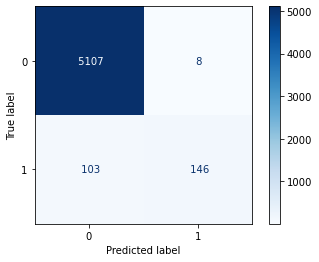

In [126]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

## Oh boy XD XD XD

1. Random Forest

In [127]:
clf = RandomForestClassifier()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7b7eccc250>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7be037a1f0>)),
                ('classifier', RandomForestClassifier())])

In [128]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, predicted))
print("Random Forest Recall:", recall_score(y_test, predicted))

Random Forest Accuracy: 0.9793064876957495
Random Forest Recall: 0.5582329317269076


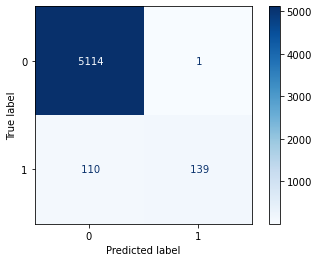

In [129]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')

XGBoost Classifier

In [130]:
clf = XGBClassifier(random_state=42)

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
#                  ("sampling", SMOTE(random_state=42))
                 ('classifier', clf)])

# fitting our model.
pipe.fit(X_train,y_train)

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f7b5d5b4bb0>),
                ('vectorizer',
                 CountVectorizer(ngram_range=(1, 3),
                                 tokenizer=<function word_tokenize at 0x7f7be037a1f0>)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
           

In [131]:
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:", accuracy_score(y_test, predicted))
print("XGBoost Recall:", recall_score(y_test, predicted))

XGBoost Accuracy: 0.9787472035794184
XGBoost Recall: 0.5622489959839357


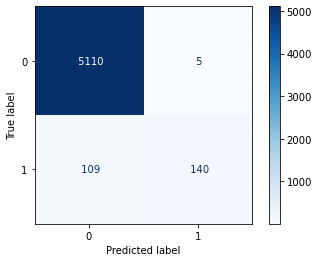

In [132]:
plot_confusion_matrix(pipe, 
                      X_test, y_test, 
                      cmap='Blues', 
                      values_format=' ')